In [2]:
import matplotlib.pyplot as plt
import numpy as np
from analysis import System

# 40 kHz Scans

In [2]:
sagnac_40kHz = System("sagnac", ["../data/20240104/40KHz_sagnac_mic/iter_" + str(n) + ".tdms" for n in range(3)], SNR_freq_cut = 1e6)
mic_40kHz = System("mic", ["../data/20240104/40KHz_sagnac_mic/iter_" + str(n) + ".tdms" for n in range(3)], SNR_freq_cut = 2e5)

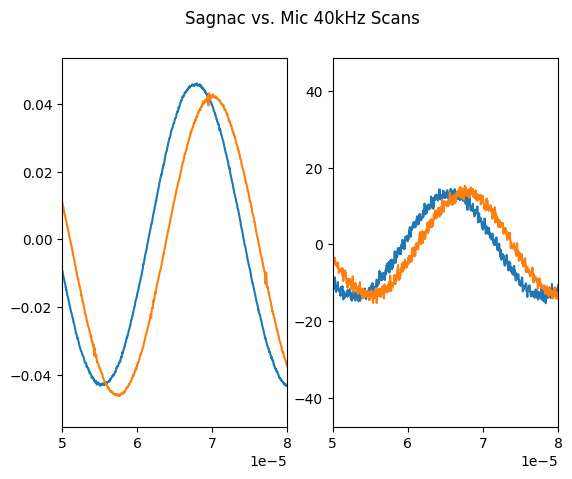

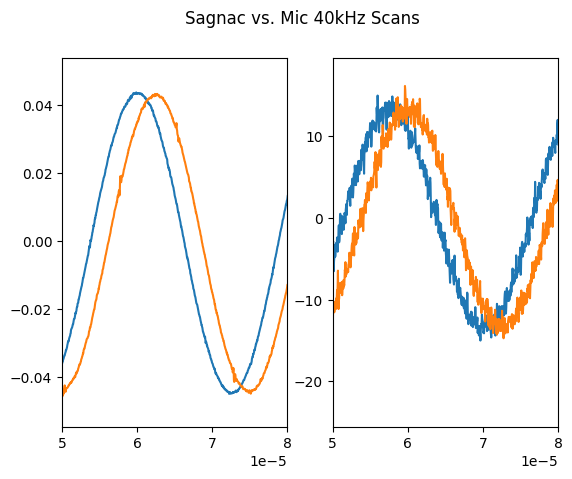

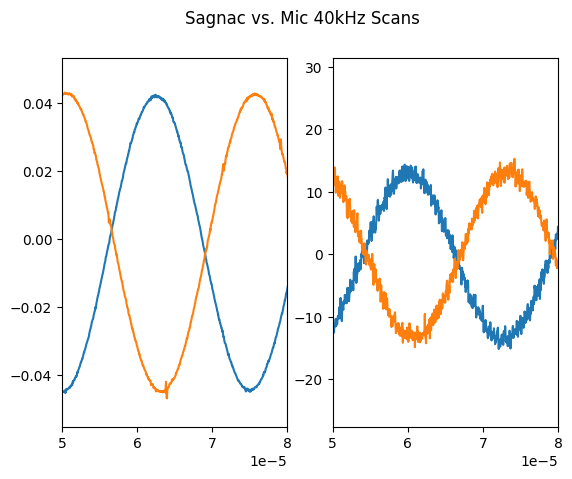

In [3]:
for sag_dat, mic_dat in zip(sagnac_40kHz.get_data(), mic_40kHz.get_data()):
    fig, ax = plt.subplots(1, 2)
    ax[0].set_xlim([0.00005, 0.00008])
    ax[1].set_xlim([0.00005, 0.00008])
    fig.suptitle("Sagnac vs. Mic 40kHz Scans")
    for sag_shot, mic_shot in zip(sag_dat.collection, mic_dat.collection):
        ax[0].plot(sag_shot.t, sag_shot.x)
        ax[1].plot(mic_shot.t, mic_shot.x)
        

# Ablation Energy Scans (20 shots)
### Starting energy = 11J
### Ending energy = 13J
##### Phi = 19

In [4]:
sagnac_ene_scan = System("sagnac", ["../data/20240104/ablation-ene-scan-11-13-20_phi-19_sagnac_mic/iter_" + str(n) + ".tdms" for n in range(20)], SNR_freq_cut = 1e6)
mic_ene_scan = System("mic", ["../data/20240104/ablation-ene-scan-11-13-20_phi-19_sagnac_mic/iter_" + str(n) + ".tdms" for n in range(20)], SNR_freq_cut = 2e5)

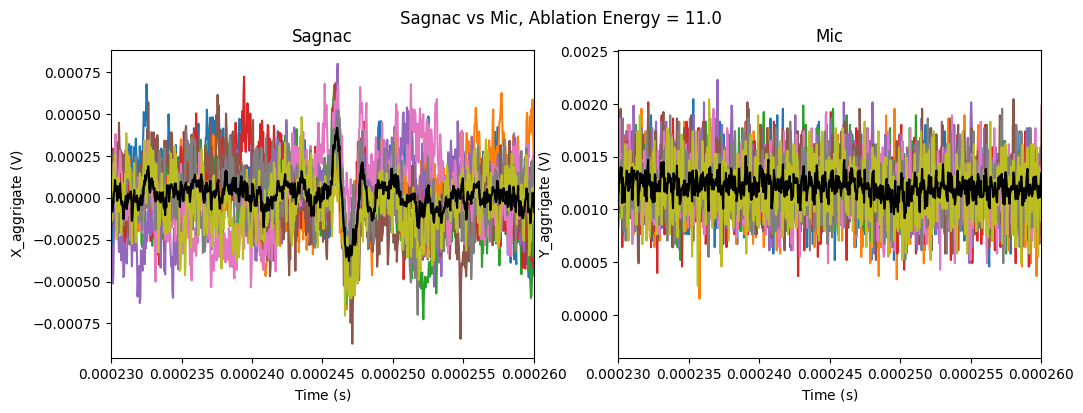

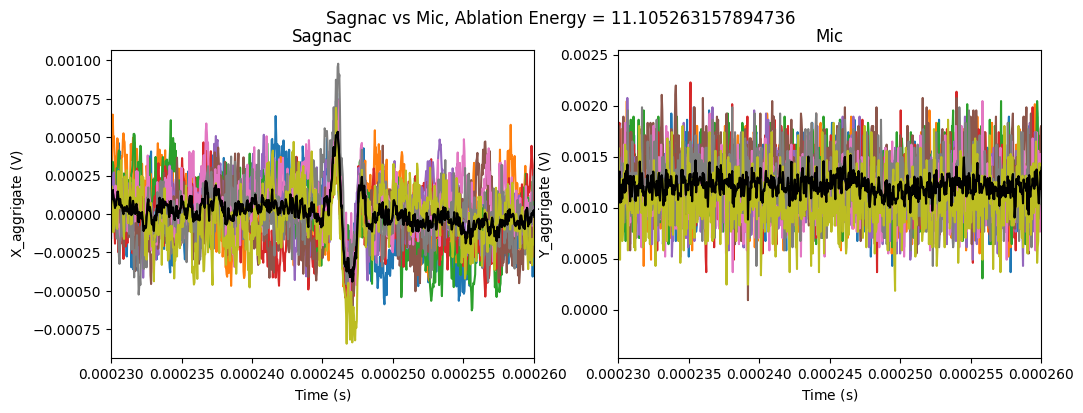

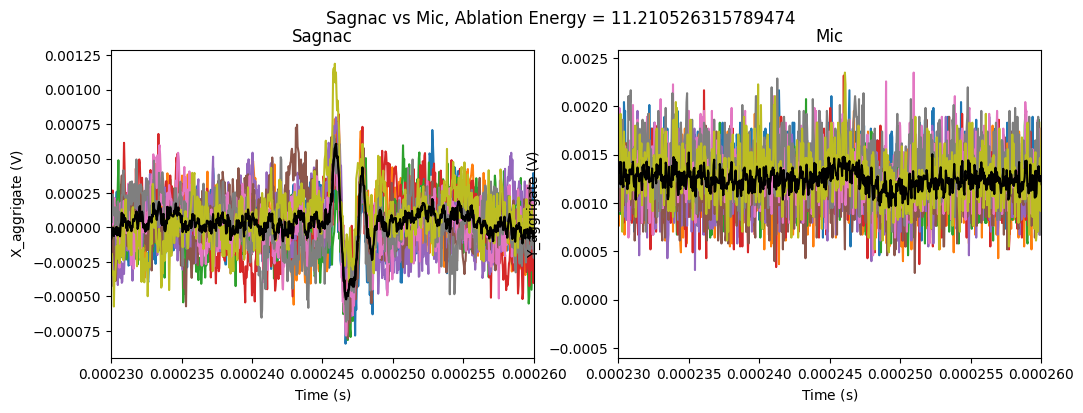

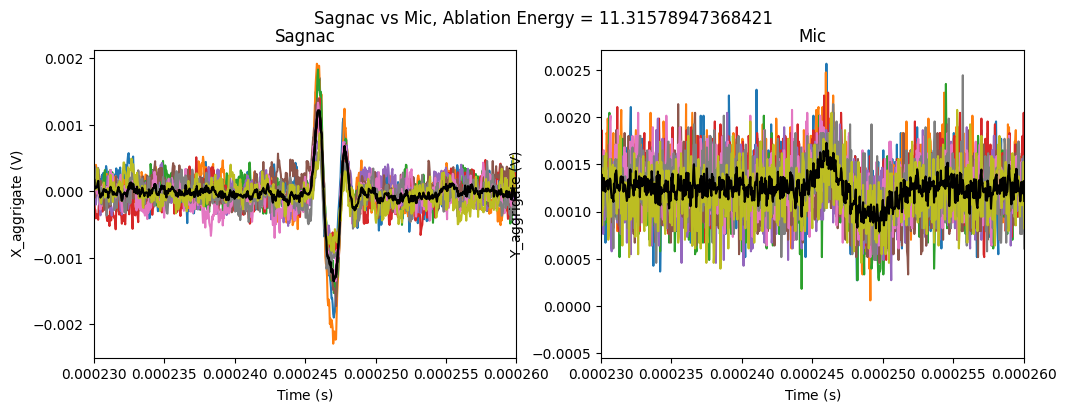

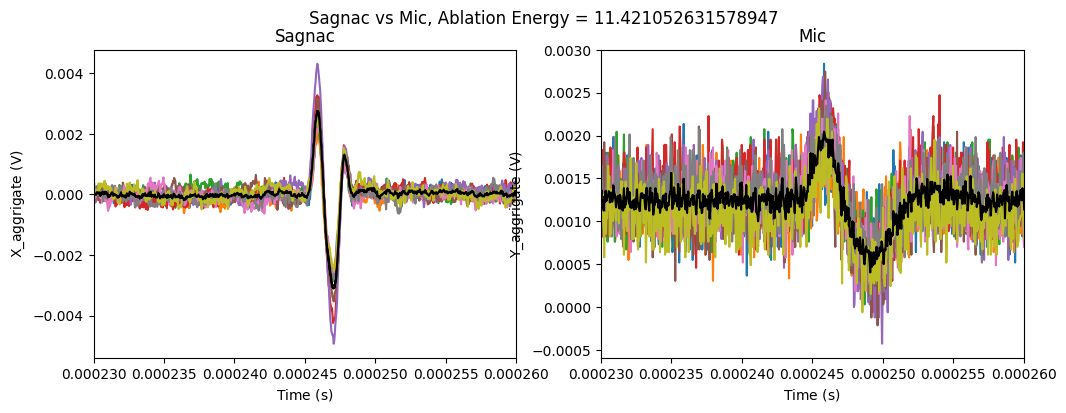

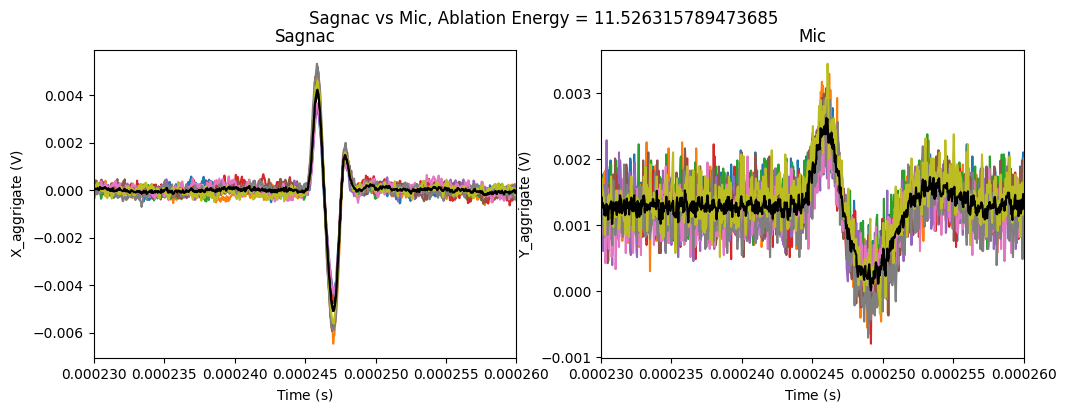

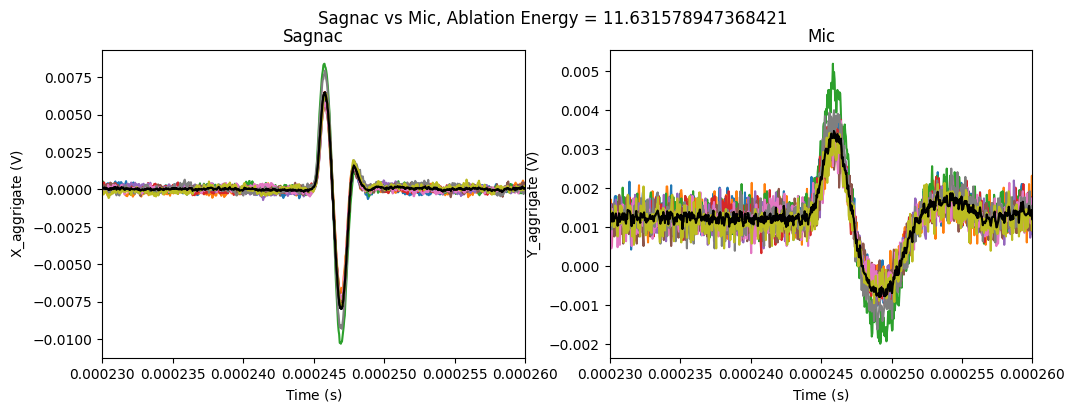

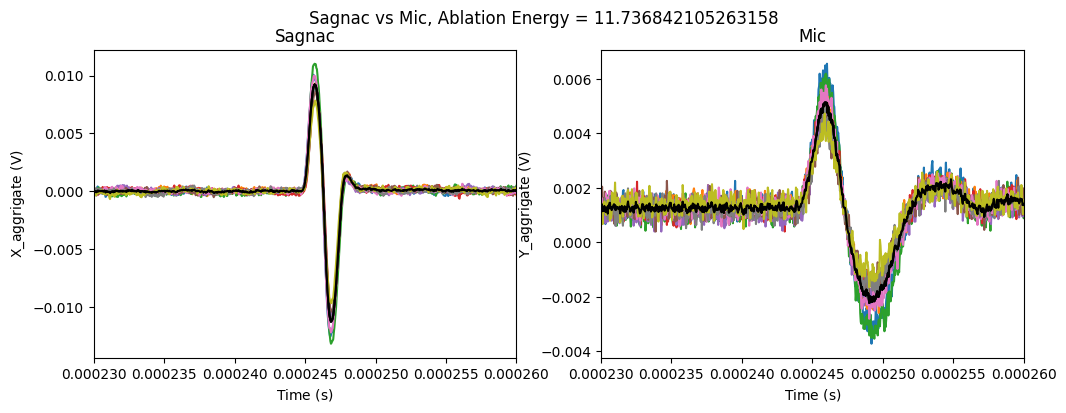

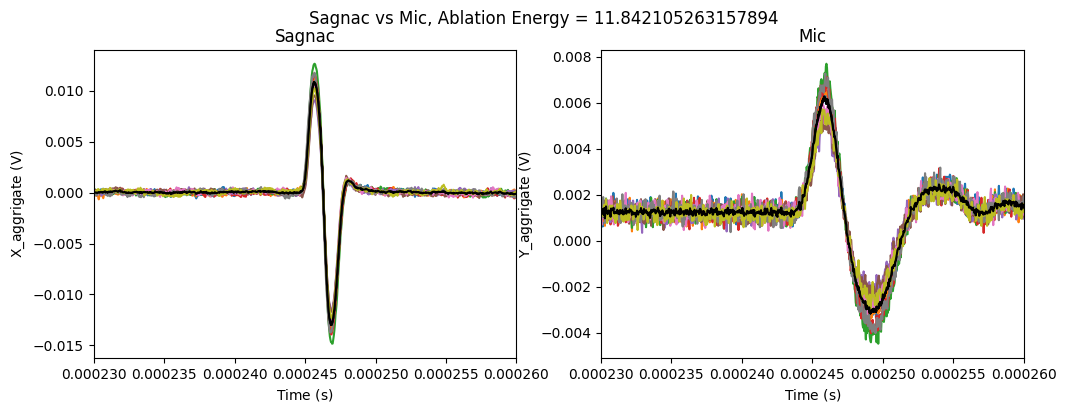

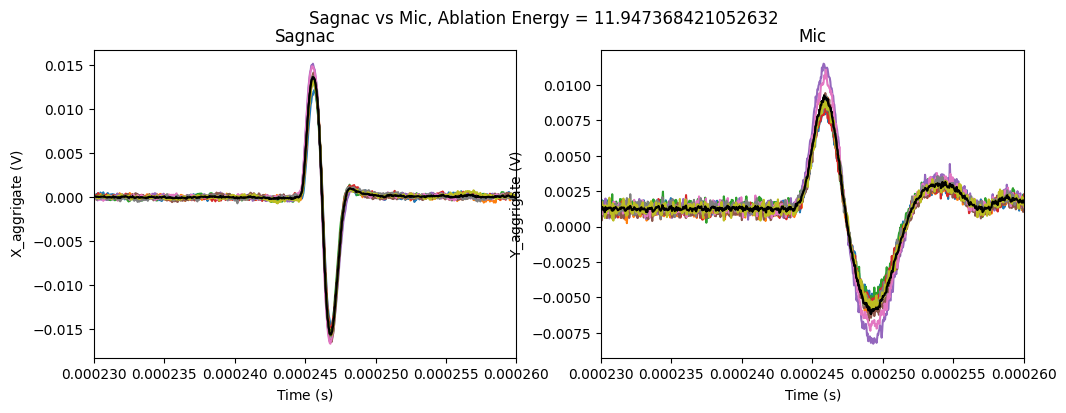

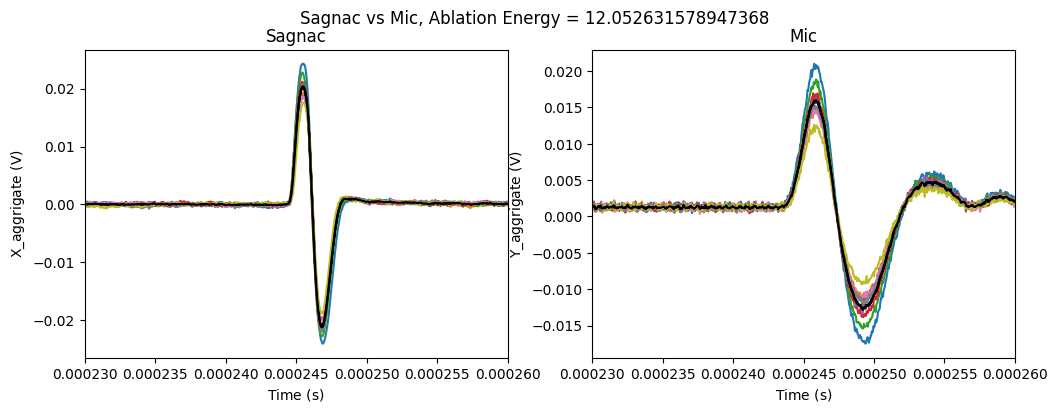

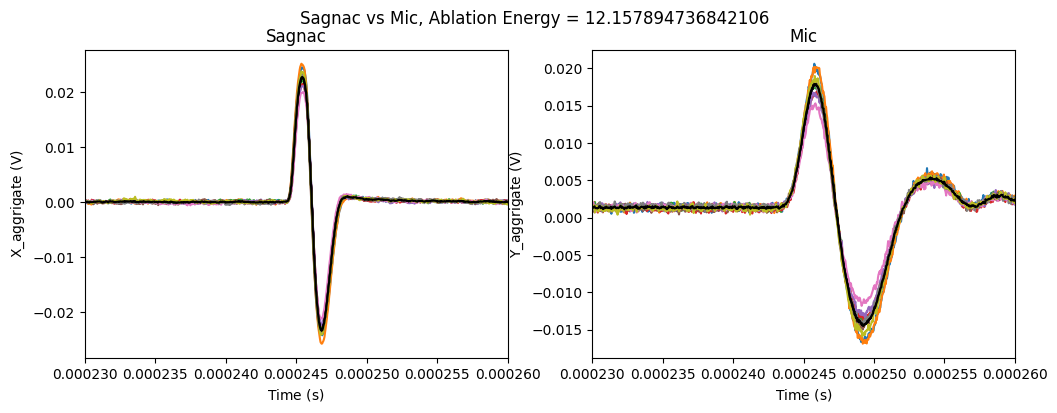

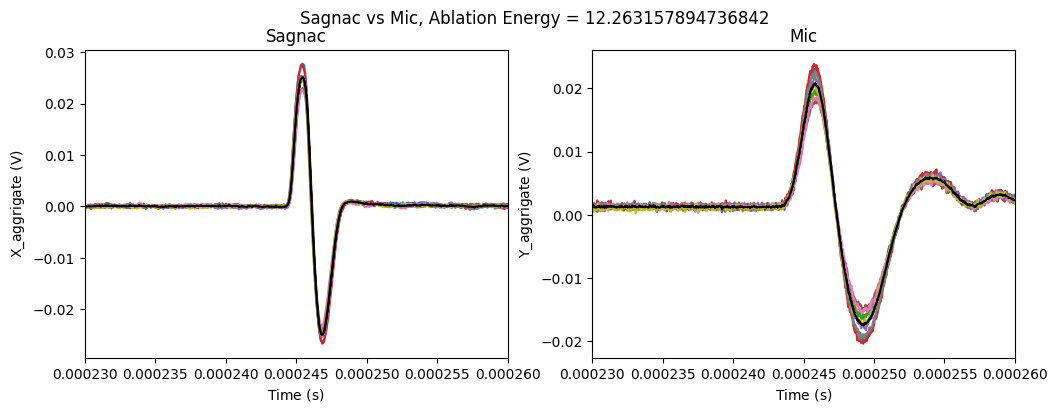

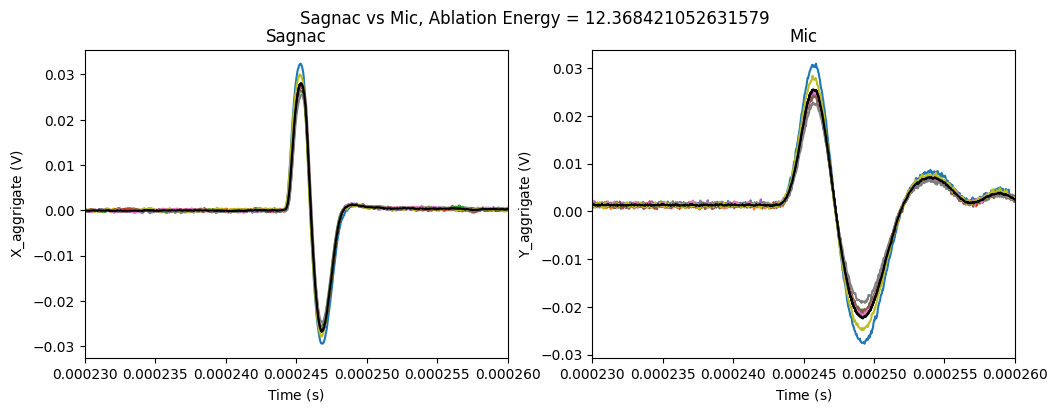

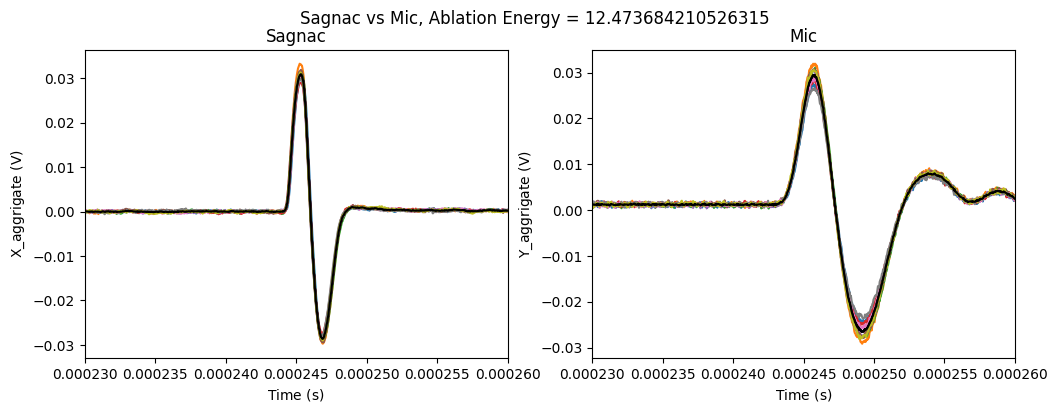

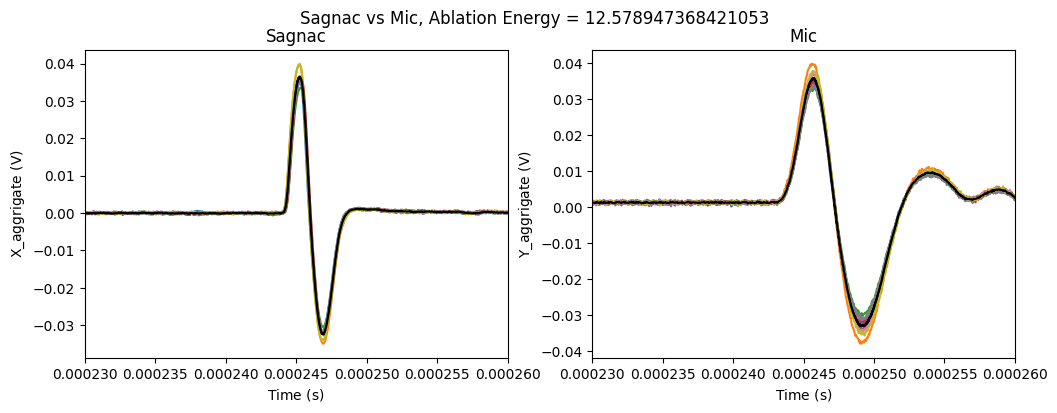

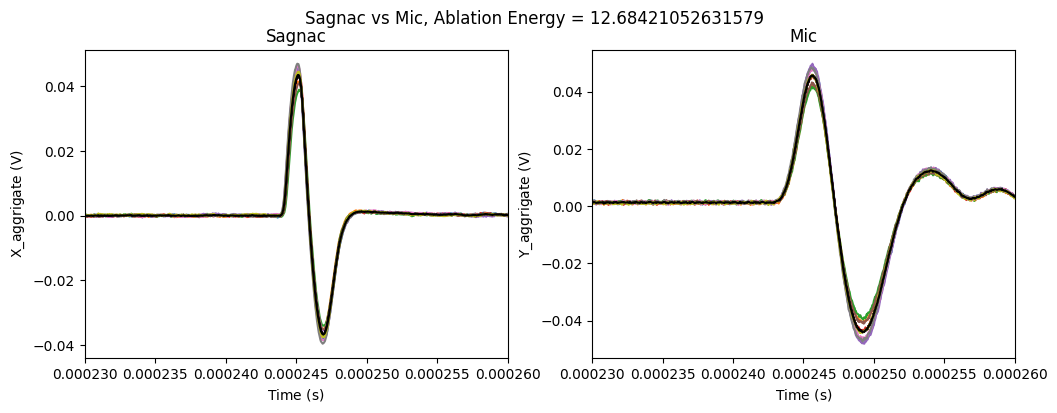

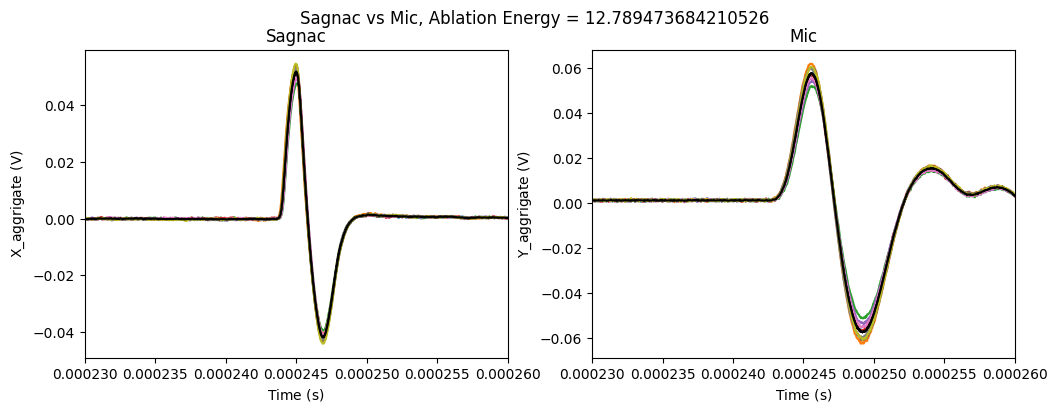

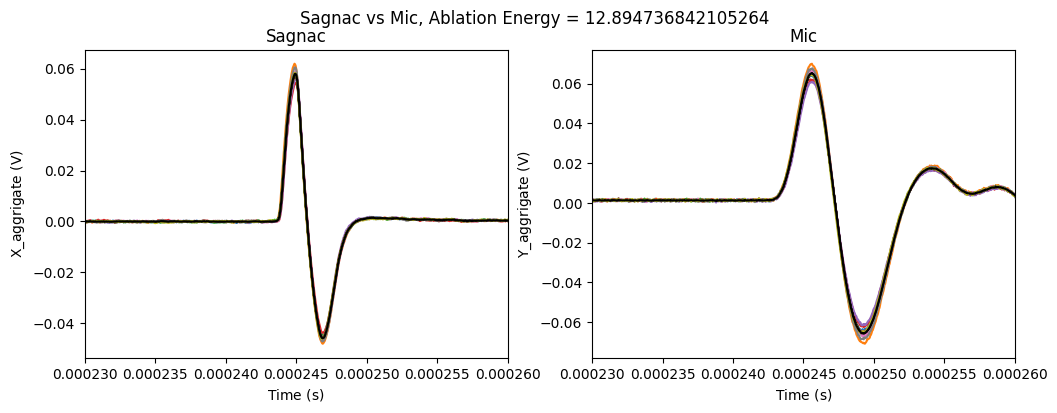

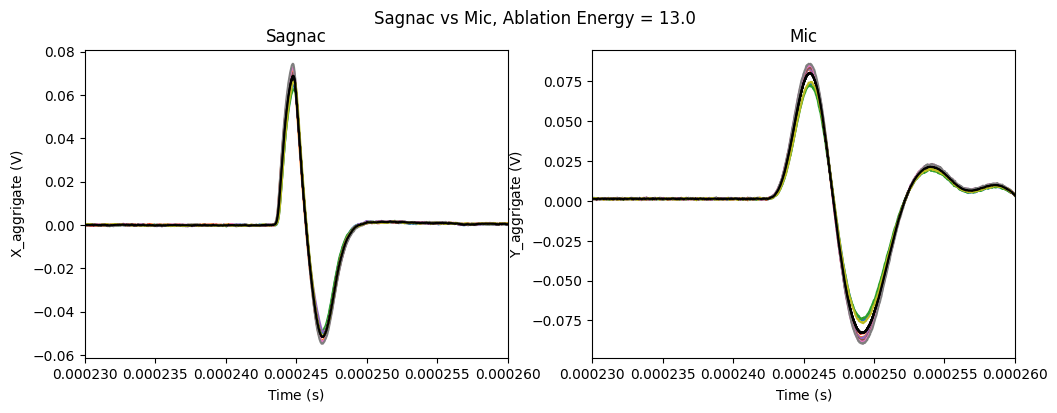

In [5]:
def Daici(freq, dist = 0.033, T = 20, n = 1.0003):
    from brownian import get_sound_speed
    from scipy.special import kv
    a = get_sound_speed(T, 0.5, 99e3)
    c = dist / a
    s = c * freq * 2j * np.pi
    return s * kv(1, s) * np.exp(s)

def integrate(freq):
    return -1j * (2 * np.pi * freq)

for i, (s_dat, m_dat) in enumerate(zip(sagnac_ene_scan.get_data(), mic_ene_scan.get_data())):
    mic_ene_scan.set_data(ind = i, mic_correct = False)
    m_dat = mic_ene_scan.get_data()[i]
    sagnac_ene_scan.set_data(ind = i)
    s_dat = sagnac_ene_scan.get_data()[i]
    
    # sagnac_ene_scan.local_detrend(index = i, tmin = 0.0002, tmax = 0.000235, inplace = True)
    s_dat.apply("correct", tmin = 0.00022, tmax = 0.00027, response = Daici, recollect = True)
    # s_dat.apply("lowpass", cutoff = 2e5, inplace = True)
    s_dat.apply("detrend", mode = "constant", inplace = True)
    # s_dat.apply("calibrate", cal = -1, inplace = True)

    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(12, 4)
    ax[0].set_title("Sagnac")
    ax[0].set_xlim([0.00023, 0.00026])
    ax[1].set_title("Mic")
    ax[1].set_xlim([0.00023, 0.00026])
    fig.suptitle("Sagnac vs Mic, Ablation Energy = " + str(s_dat.ene))
    for s_shot, m_shot in zip(s_dat.collection[2:], m_dat.collection[2:]):
        s_dat.aggrigate(collection_slice = slice(2, len(s_dat.collection), 1))
        ax[0].plot(s_shot.t, s_shot.x)
        s_dat.agg.plot(ax = ax[0], c = "k")
        m_dat.aggrigate(collection_slice = slice(2, len(m_dat.collection), 1))
        ax[1].plot(m_shot.t, m_shot.x)
        m_dat.agg.plot(ax = ax[1], c = "k")
    
    mic_ene_scan.set_data(ind = i, mic_correct = False)
    m_dat = mic_ene_scan.get_data()[i]
    sagnac_ene_scan.set_data(ind = i)
    s_dat = sagnac_ene_scan.get_data()[i]

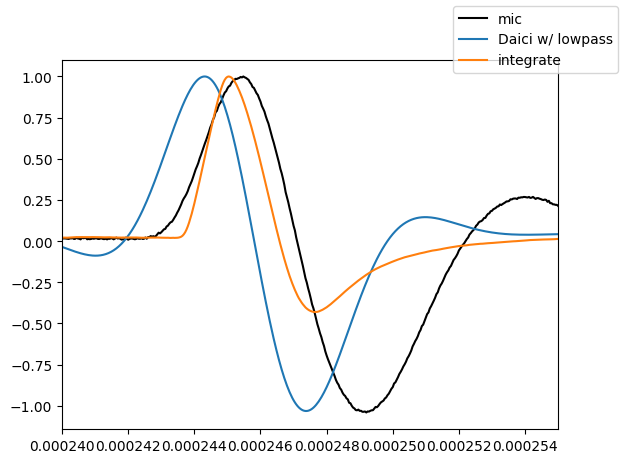

In [6]:
fig, ax = plt.subplots()
ax.set_xlim([0.00024, 0.000255])

m_dat.apply("calibrate", cal = 1 / max(m_dat.collection[8].x), inplace = True)
t, x = m_dat.collection[8].t, m_dat.collection[8].x

ax.plot(t, x, label = "mic", c = "k")

sagnac_ene_scan.set_data(ind = 19)
s_dat = sagnac_ene_scan.get_data()[19]
mic_ene_scan.set_data(ind = 19, mic_correct = False)
m_dat = mic_ene_scan.get_data()[19]

# s_dat.apply("detrend", mode = "constant", inplace = True)
# s_dat.apply("calibrate", cal = 1 / max(s_dat.collection[8].x), inplace = True)
# t, x = s_dat.collection[8].t, s_dat.collection[8].x
# ax.plot(t, x, label = "raw")
# sagnac_ene_scan.set_data(ind = 19)
# s_dat = sagnac_ene_scan.get_data()[19]


s_dat.apply("detrend", mode = "constant", inplace = True)
s_dat.apply("correct", tmin = 0.00022, tmax = 0.00027, response = Daici, recollect = True)
# s_dat.apply("lowpass", cutoff = 2e5, inplace = True)
s_dat.apply("calibrate", cal = 1 / max(s_dat.collection[8].x), inplace = True)
t, x = s_dat.collection[8].t, s_dat.collection[8].x
ax.plot(t, x, label = "Daici w/ lowpass")
sagnac_ene_scan.set_data(ind = 19)
s_dat = sagnac_ene_scan.get_data()[19]

# s_dat.apply("detrend", mode = "constant", inplace = True)
# s_dat.apply("correct", response = integrate, recollect = True)
# s_dat.apply("calibrate", cal = -1, inplace = True)
# s_dat.apply("calibrate", cal = 1 / max(s_dat.collection[8].x), inplace = True)
# t, x = s_dat.collection[8].t, s_dat.collection[8].x
# ax.plot(t, x, label = "integrate")
# sagnac_ene_scan.set_data(ind = 19)
# s_dat = sagnac_ene_scan.get_data()[19]

sagnac_ene_scan.set_data(ind = 19)
s_dat = sagnac_ene_scan.get_data()[19]
mic_ene_scan.set_data(ind = 19, mic_correct = False)
m_dat = mic_ene_scan.get_data()[19]
fig.legend()

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from analysis import System

sagnac_ene_scan = System("sagnac", ["../data/20240105/ablation-ene-scan-11-12-20_phi-154_sagnac_mic/iter_" + str(n) + ".tdms" for n in range(20)], SNR = False)
mic_ene_scan = System("mic", ["../data/20240105/ablation-ene-scan-11-12-20_phi-154_sagnac_mic/iter_" + str(n) + ".tdms" for n in range(20)], SNR = False)

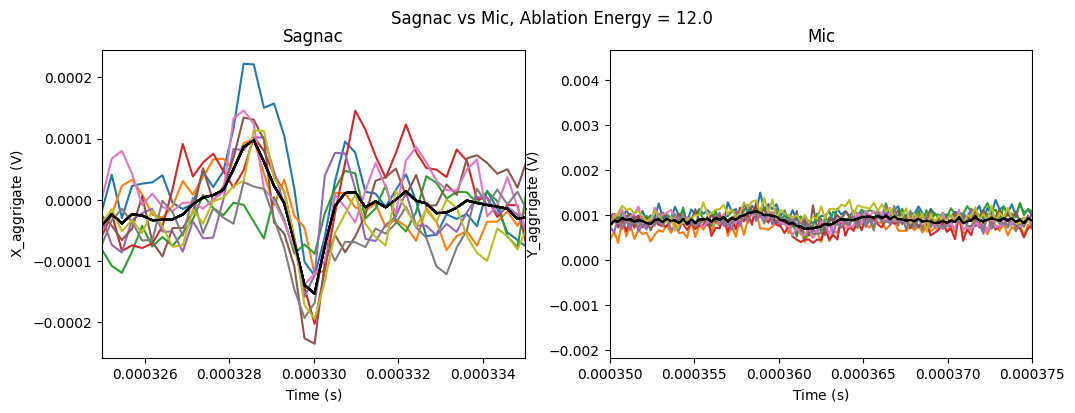

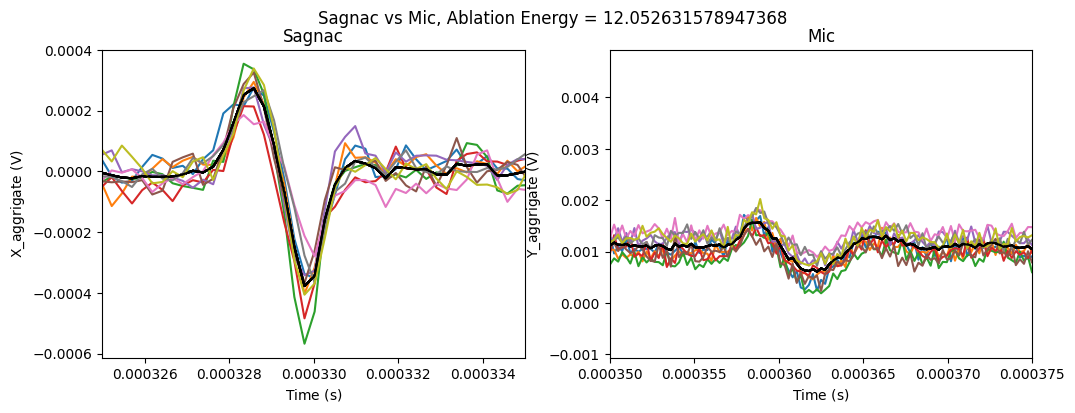

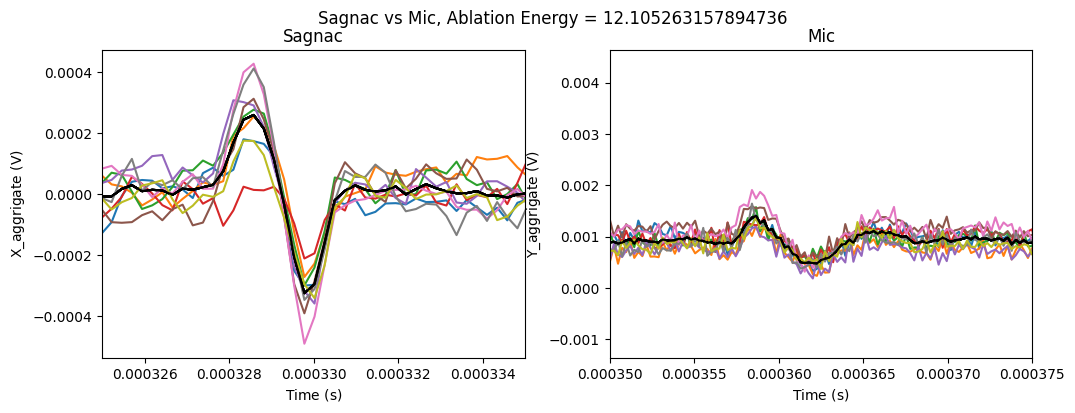

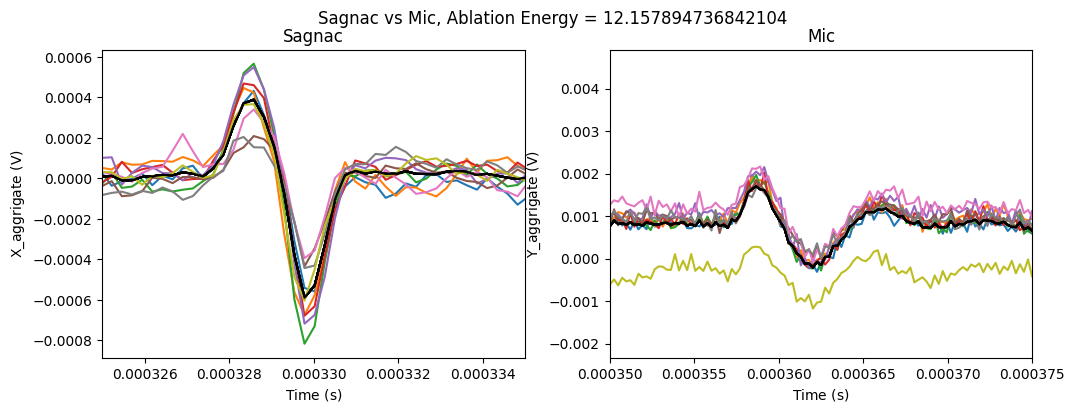

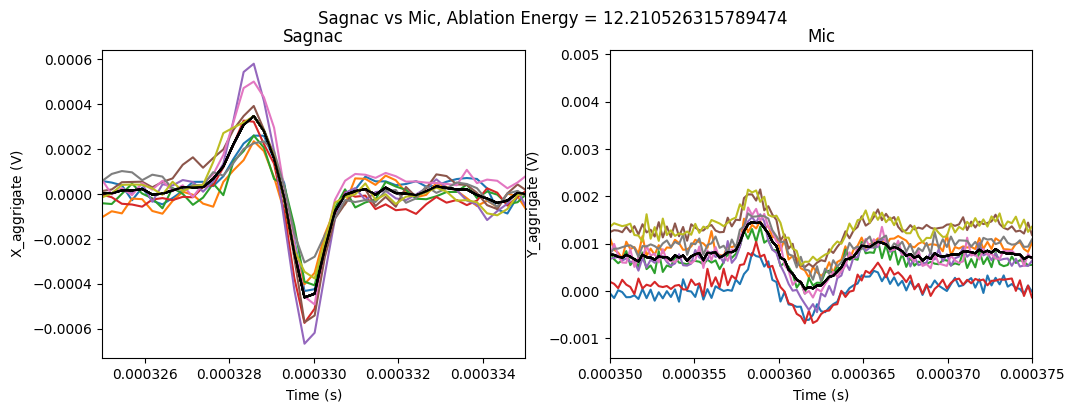

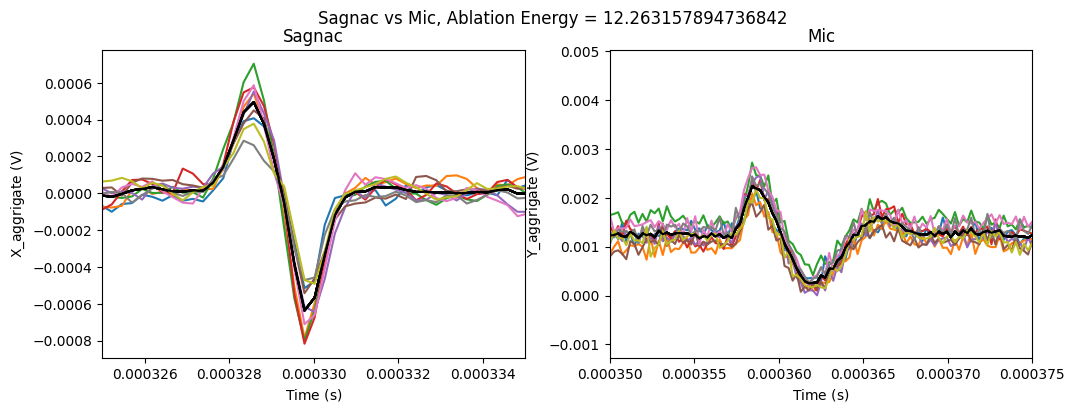

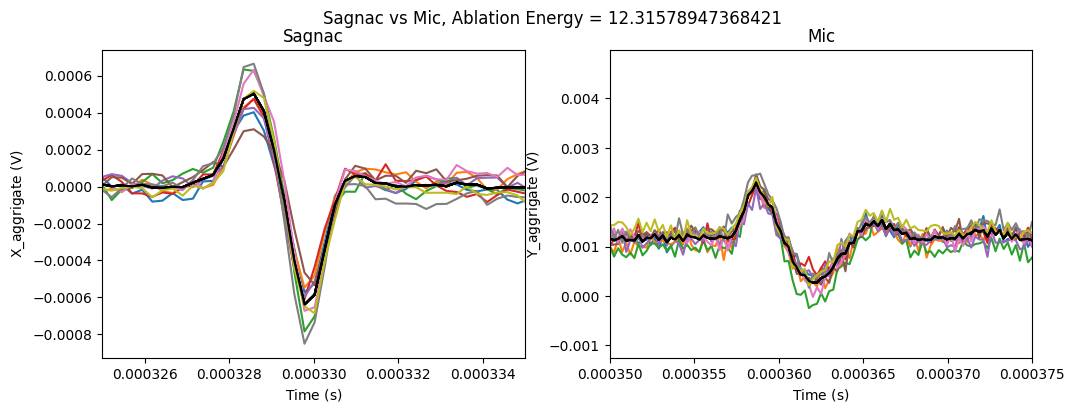

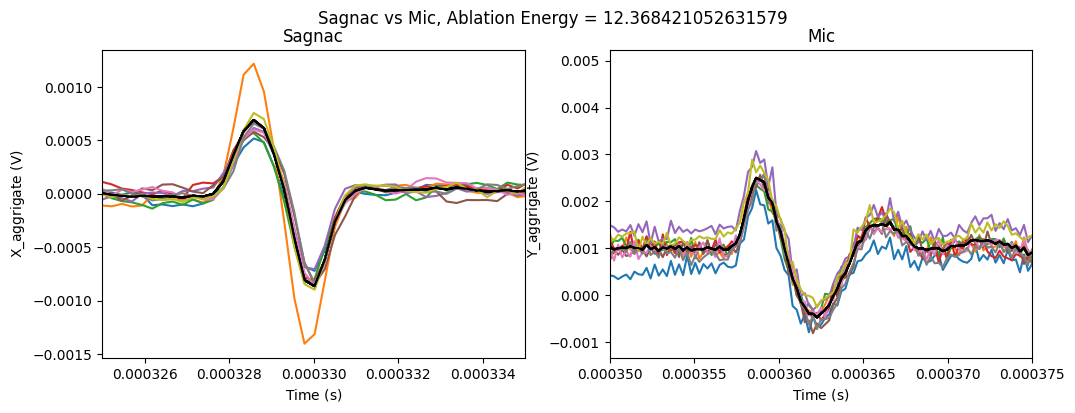

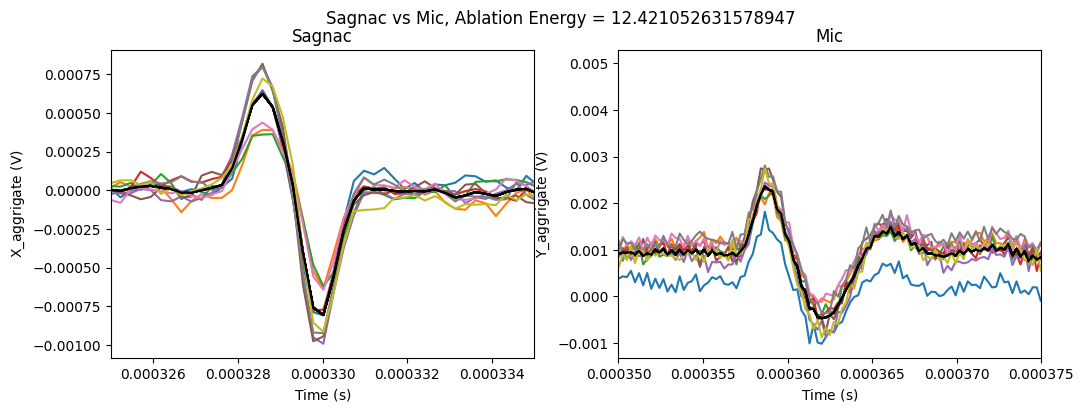

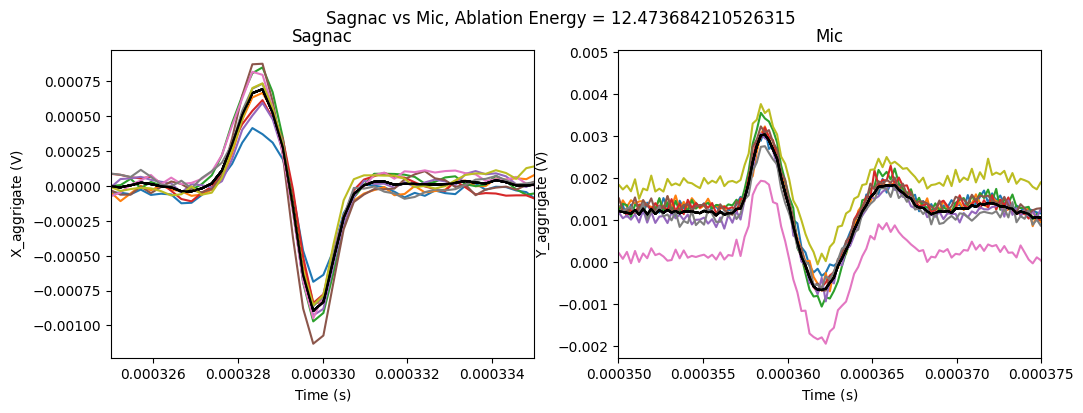

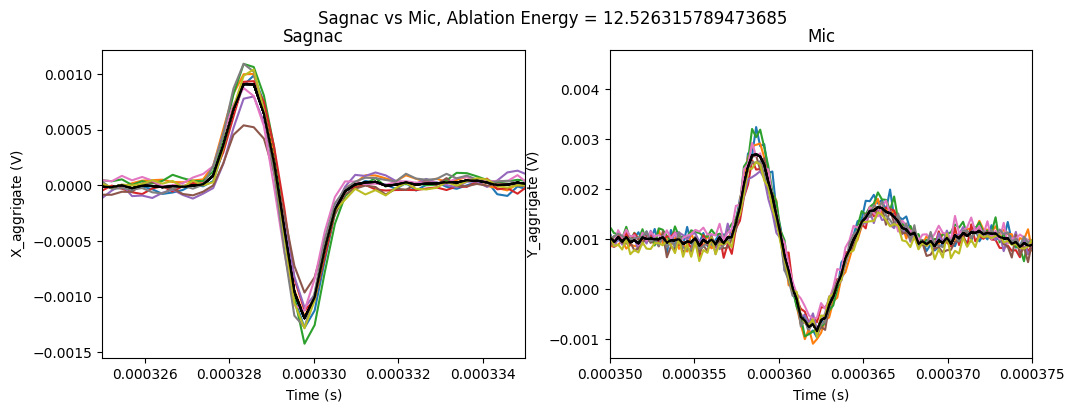

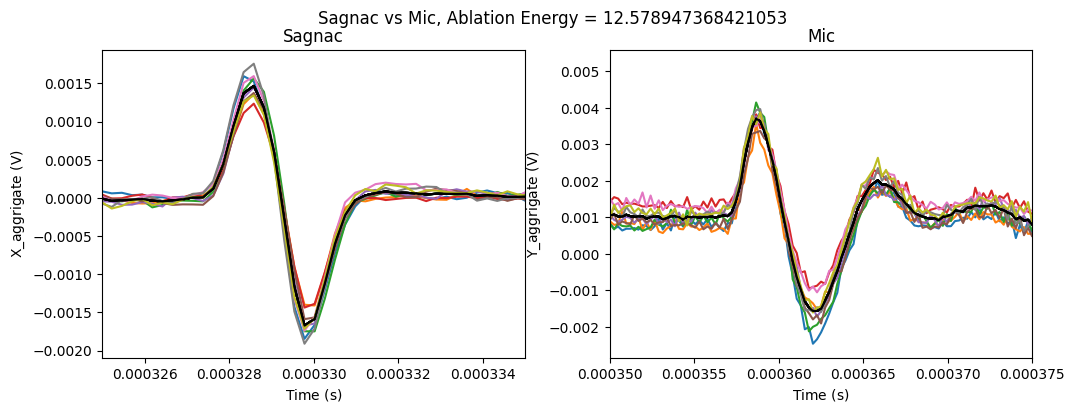

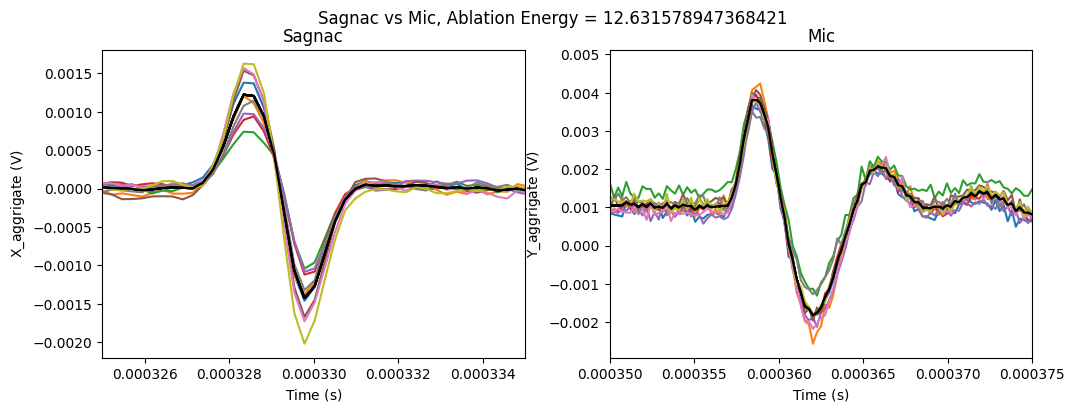

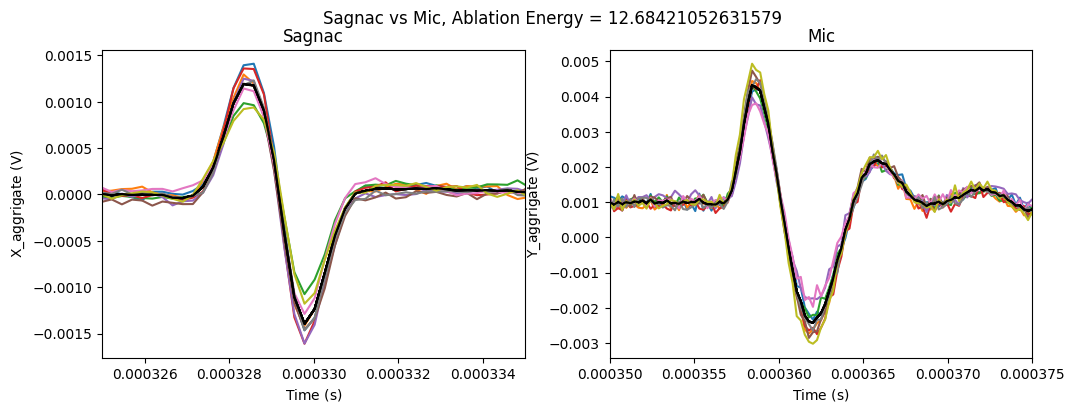

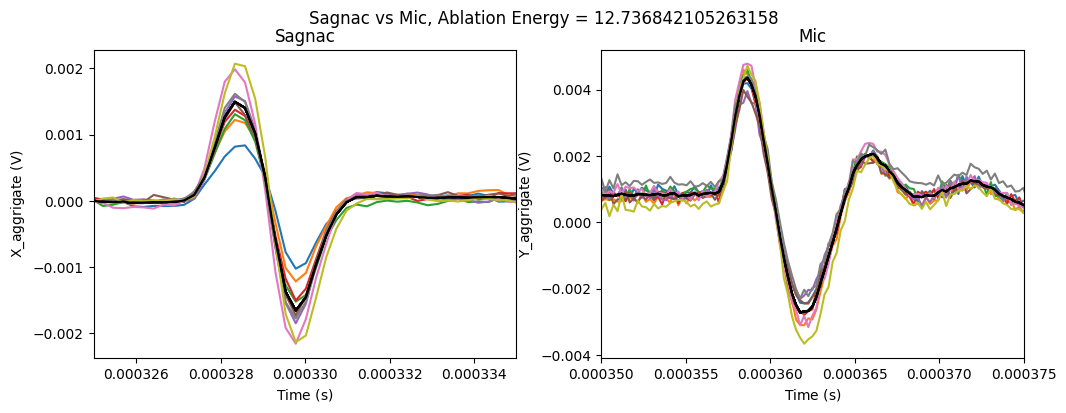

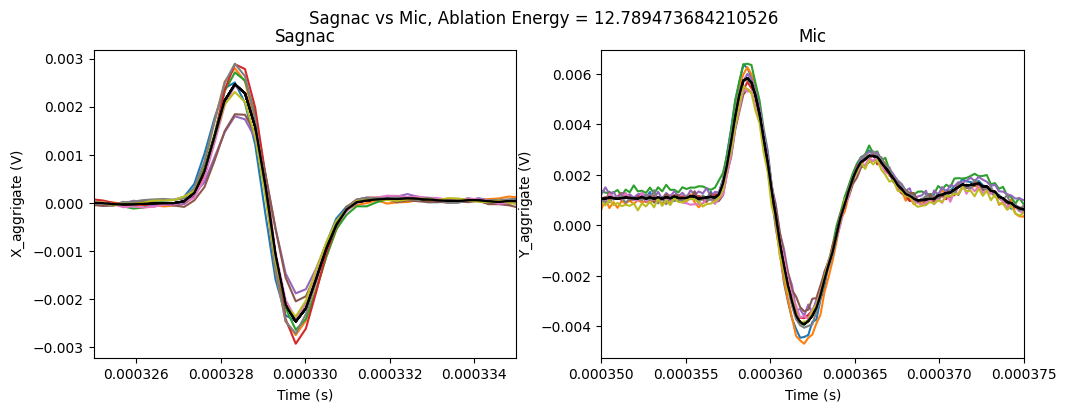

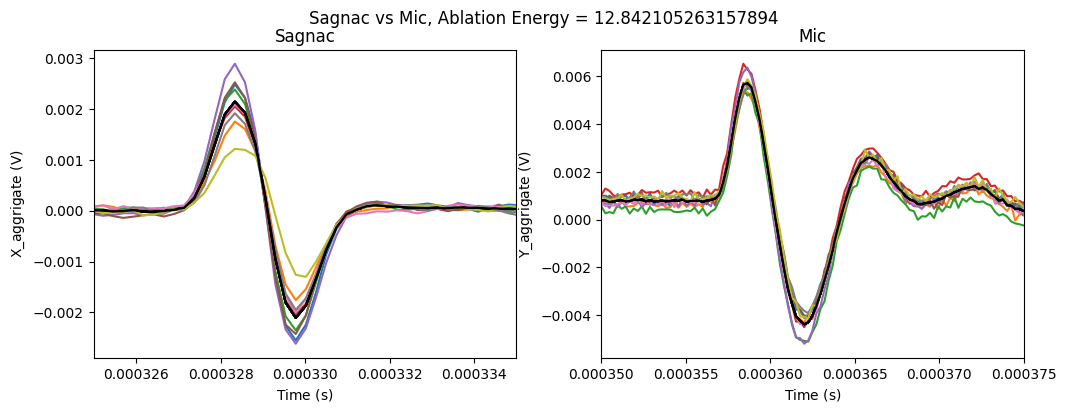

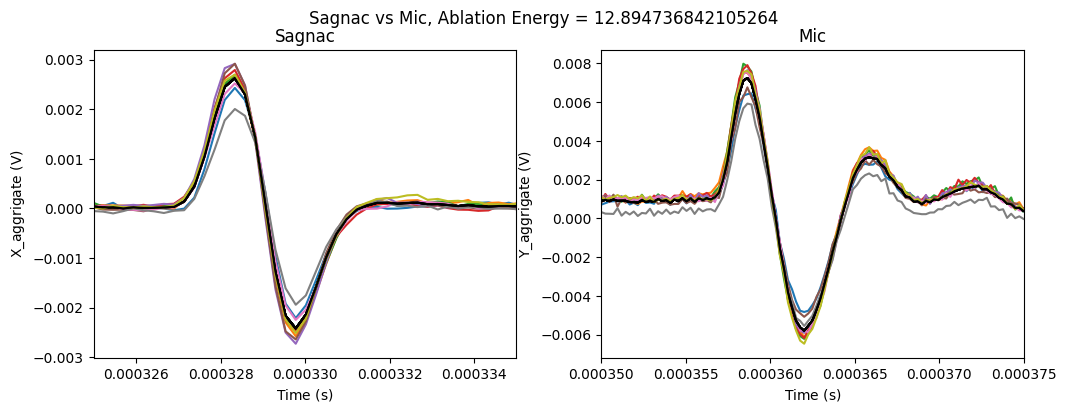

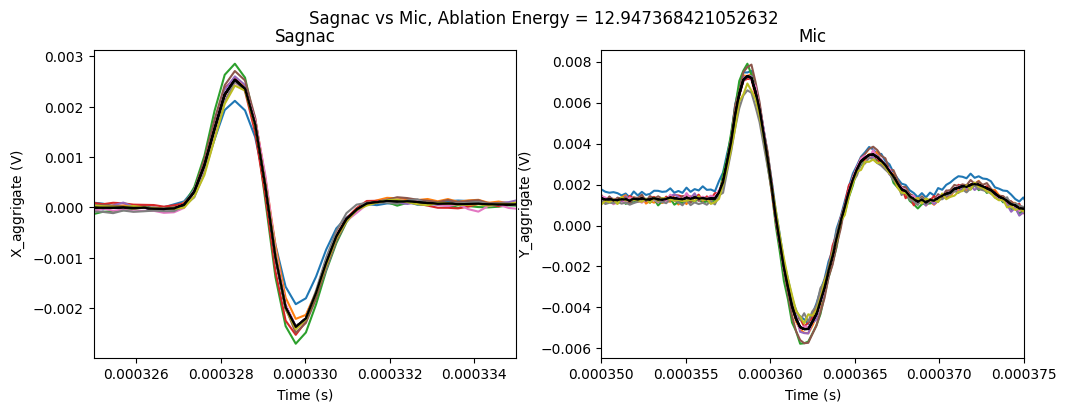

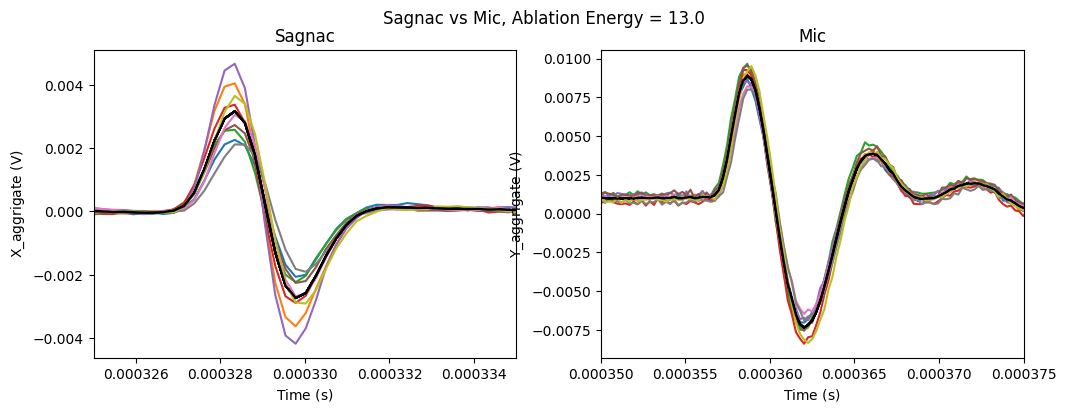

In [2]:
def Daici(freq, dist = 0.085, T = 20, n = 1.0003):
    from brownian import get_sound_speed
    from scipy.special import kv
    a = get_sound_speed(T, 0.5, 99e3)
    c = dist / a
    s = c * freq * 2j * np.pi
    return s * kv(1, s) * np.exp(s)

def integrate(freq):
    return -1j * (2 * np.pi * freq)

for i, (s_dat, m_dat) in enumerate(zip(sagnac_ene_scan.get_data(), mic_ene_scan.get_data())):
    mic_ene_scan.set_data(ind = i, mic_correct = False)
    m_dat = mic_ene_scan.get_data()[i]
    sagnac_ene_scan.set_data(ind = i)
    s_dat = sagnac_ene_scan.get_data()[i]

    m_dat.apply("bin_average", Npts = int(m_dat.r / (2e6 * 2)), inplace = True)
    
    # sagnac_ene_scan.local_detrend(index = i, tmin = 0.0002, tmax = 0.000235, inplace = True)
    s_dat.apply("correct", tmin = 0.00031, tmax = 0.000375, response = Daici, recollect = True)
    s_dat.apply("bin_average", Npts = int(s_dat.r / (2e6 * 2)), inplace = True)
    # s_dat.apply("lowpass", cutoff = 2e5, inplace = True)
    s_dat.apply("detrend", mode = "constant", inplace = True)
    # s_dat.apply("calibrate", cal = -1, inplace = True)

    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(12, 4)
    ax[0].set_title("Sagnac")
    ax[0].set_xlim([0.000325, 0.000335])
    ax[1].set_title("Mic")
    ax[1].set_xlim([0.00035, 0.000375])
    fig.suptitle("Sagnac vs Mic, Ablation Energy = " + str(s_dat.ene))
    for s_shot, m_shot in zip(s_dat.collection[2:], m_dat.collection[2:]):
        s_dat.aggrigate(collection_slice = slice(2, len(s_dat.collection), 1))
        ax[0].plot(s_shot.t, s_shot.x)
        s_dat.agg.plot(ax = ax[0], c = "k")
        m_dat.aggrigate(collection_slice = slice(2, len(m_dat.collection), 1))
        ax[1].plot(m_shot.t, m_shot.x)
        m_dat.agg.plot(ax = ax[1], c = "k")
    
    mic_ene_scan.set_data(ind = i, mic_correct = False)
    m_dat = mic_ene_scan.get_data()[i]
    sagnac_ene_scan.set_data(ind = i)
    s_dat = sagnac_ene_scan.get_data()[i]

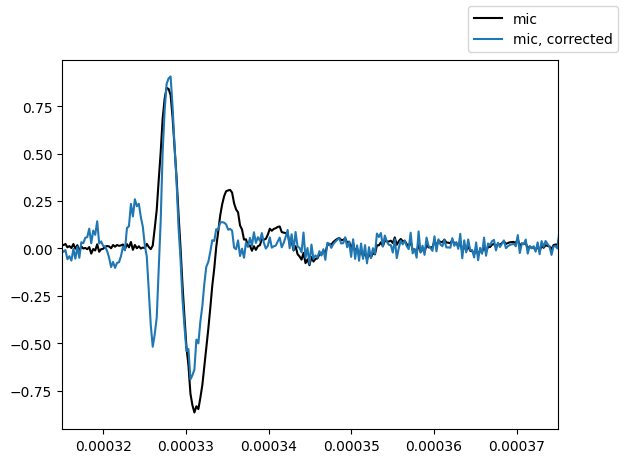

In [4]:
fig, ax = plt.subplots()
ax.set_xlim([0.000315, 0.000375])

i = 19

sagnac_ene_scan.set_data(ind = i)
s_dat = sagnac_ene_scan.get_data()[i]

mic_ene_scan.set_data(ind = i, mic_correct = False)
m_dat = mic_ene_scan.get_data()[i]
m_dat.apply("calibrate", cal = 1 / max(m_dat.collection[8].x), inplace = True)
m_dat.apply("detrend", mode = "constant", inplace = True)
m_dat.apply("shift", tau = 0.000031, inplace = True)
m_dat.apply("bin_average", Npts = int(m_dat.r / (2e6 * 2)), inplace = True)
t, x = m_dat.collection[8].t, m_dat.collection[8].x

ax.plot(t, x, label = "mic", c = "k")

mic_ene_scan.set_data(ind = i, mic_correct = True)
m_dat = mic_ene_scan.get_data()[i]
m_dat.apply("calibrate", cal = 1 / max(m_dat.collection[8].x), inplace = True)
m_dat.apply("detrend", mode = "constant", inplace = True)
m_dat.apply("shift", tau = 0.000031, inplace = True)
m_dat.apply("bin_average", Npts = int(m_dat.r / (2e6 * 2)), inplace = True)
t, x = m_dat.collection[8].t, m_dat.collection[8].x

ax.plot(t, x, label = "mic, corrected")

# s_dat.apply("detrend", mode = "constant", inplace = True)
# s_dat.apply("calibrate", cal = 1 / max(s_dat.collection[8].x), inplace = True)
# t, x = s_dat.collection[8].t, s_dat.collection[8].x
# ax.plot(t, x, label = "raw")
# sagnac_ene_scan.set_data(ind = i)
# s_dat = sagnac_ene_scan.get_data()[i]


# s_dat.apply("correct", tmin = 0.00031, tmax = 0.000375, response = Daici, recollect = True)
# s_dat.apply("detrend", mode = "constant", inplace = True)
# s_dat.apply("bin_average", Npts = int(s_dat.r / (2e6 * 2)), inplace = True)
# # s_dat.apply("lowpass", cutoff = 2e5, inplace = True)
# s_dat.apply("calibrate", cal = 1 / max(s_dat.collection[8].x), inplace = True)
# t, x = s_dat.collection[8].t, s_dat.collection[8].x
# ax.plot(t, x, label = "Daici w/o lowpass")
# sagnac_ene_scan.set_data(ind = i)
# s_dat = sagnac_ene_scan.get_data()[i]

# s_dat.apply("correct", response = integrate, recollect = True)
# s_dat.apply("detrend", mode = "constant", inplace = True)
# s_dat.apply("lowpass", cutoff = 2e5, inplace = True)
# s_dat.apply("calibrate", cal = -1, inplace = True)
# s_dat.apply("calibrate", cal = 1 / max(s_dat.collection[8].x), inplace = True)
# t, x = s_dat.collection[8].t, s_dat.collection[8].x
# ax.plot(t, x, label = "integrate")
# sagnac_ene_scan.set_data(ind = i)
# s_dat = sagnac_ene_scan.get_data()[i]


sagnac_ene_scan.set_data(ind = i)
s_dat = sagnac_ene_scan.get_data()[i]
mic_ene_scan.set_data(ind = i, mic_correct = False)
m_dat = mic_ene_scan.get_data()[i]
fig.legend()

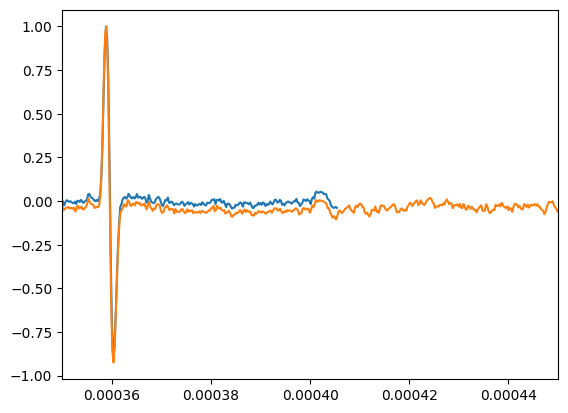

In [96]:
import acoustic_entrainment
import scipy.signal as sig

fig, ax = plt.subplots()
ax.set_xlim([0.00035, 0.00045])

def Daici(freq, dist = 0.09, T = 20, n = 1.0003):
    from brownian import get_sound_speed
    from scipy.special import kv
    a = get_sound_speed(T, 0.5, 99e3)
    c = dist / a
    s = c * freq * 2j * np.pi
    return s * kv(1, s) * np.exp(s)
    
def laser_impulse(t, dist = 0.09, T = 20, n = 1.0003):
    from brownian import get_sound_speed
    a = get_sound_speed(T, 0.5, 99e3)
    tau = dist / a
    return (tau ** 2) / np.power((t * (t + (2 * tau))), (3/2))

s_dat.apply("correct", response = Daici, recollect = True)
s_dat.apply("detrend", mode = "constant", inplace = True)
s_dat.apply("bin_average", Npts = int(s_dat.r / (2e6 * 2)), inplace = True)
s_dat.apply("shift", tau = -0.0000305, inplace = True)
t, x = s_dat.collection[8].t, s_dat.collection[8].x
x /= np.max(x)
ax.plot(t, x, label = "Daici")
sagnac_ene_scan.set_data(ind = i)
s_dat = sagnac_ene_scan.get_data()[i]

freq = np.linspace(1, 3e6, 1000)
gains = Daici(freq)
filter = sig.firwin2(len(gains) - 1, np.r_[0, freq], np.r_[0, gains] ** 2, fs = 2 * freq[-1])
kernel = sig.minimum_phase(filter)
inv_kernel = np.fft.ifft(1 / np.fft.fft(kernel))
s_dat.apply("detrend", mode = "constant", inplace = True)
s_dat.apply("bin_average", Npts = int(s_dat.r / (2e6 * 2)), inplace = True)
s_dat.apply("shift", tau = -0.0000305, inplace = True)
t0, x0 = s_dat.collection[8].t, s_dat.collection[8].x
x0 /= np.max(x0)
# ax.plot(t0, x0, label = "sagnac")
t, x = s_dat.collection[8].t, sig.lfilter(inv_kernel, [1], s_dat.collection[8].x)
x /= np.max(x)
ax.plot(t, x, label = "sagnac")
sagnac_ene_scan.set_data(ind = i)
s_dat = sagnac_ene_scan.get_data()[i]

lfs = 0.68 * 1e-3
gains = lfs * 10 ** (acoustic_entrainment.dBs_orig / 20)
filter = sig.firwin2(len(gains), np.r_[0, acoustic_entrainment.fs_orig], np.r_[lfs, gains] ** 2, fs = 2 * acoustic_entrainment.fs_orig[-1])
min_filter = sig.minimum_phase(filter)
inv_kernel = np.fft.ifft(1 / np.fft.fft(min_filter))
m_dat.apply("detrend", mode = "constant", inplace = True)
m_dat.apply("bin_average", Npts = int(m_dat.r / (2e6 * 2)), inplace = True)
# t0, x0 = m_dat.collection[8].t, m_dat.collection[8].x
# x0 /= np.max(x0)
# ax.plot(t0, x0)
# t, x = m_dat.collection[8].t, sig.lfilter(inv_kernel, [1], m_dat.collection[8].x)
# x /= np.max(x)
# ax.plot(t, x)
mic_ene_scan.set_data(ind = i, mic_correct = False)
m_dat = mic_ene_scan.get_data()[i]